<a href="https://colab.research.google.com/github/mlacasa/EstadisticaQ2/blob/main/Actividad1_Supervivencia2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad 1B — Análisis de Supervivencia (Log-rank + Cox)

## 🧩 Contexto
En este bloque trabajaremos con un conjunto de datos clínicos clásico de supervivencia (cáncer de pulmón), donde cada paciente tiene:
- un **tiempo de seguimiento** (hasta el evento o hasta el final del estudio)
- un indicador de **evento** (si el evento ocurrió o si el paciente quedó **censurado**)

El objetivo es responder preguntas del tipo:
- ¿Dos grupos (p. ej., hombres vs mujeres) tienen **curvas de supervivencia distintas**?
- Ajustando por varias covariables, ¿qué variables se asocian a un **mayor riesgo** de evento?

## 🎯 Qué vas a aprender / practicar
1) Representar supervivencia con **Kaplan–Meier**  
2) Comparar grupos mediante **log-rank test**  
3) Ajustar un modelo multivariable con **Cox Proportional Hazards**  
4) Interpretar correctamente: **censura**, **hazard ratio**, IC95% y significación estadística  
5) (Extra) Revisar el supuesto de **riesgos proporcionales** de forma básica

## 📦 Dataset
Usaremos el dataset **lung** (NCCTG Lung Cancer), disponible públicamente y cargado desde un CSV en GitHub.

> ⚠️ Nota: en supervivencia, una parte importante del trabajo es asegurarte de que:
> - el tiempo está en la unidad correcta (días, semanas…)
> - el indicador de evento está codificado correctamente (1 = evento, 0 = censura)

## ✅ Entregable dentro del Notebook
Al final del cuaderno, debes incluir un breve apartado de conclusión:
- qué grupos comparaste y qué obtuviste (log-rank)
- qué variables fueron relevantes en Cox (HR e interpretación)
- 2–3 limitaciones o precauciones del análisis (p. ej. supuestos, tamaños, missing)


In [2]:
# CELDA 1 — Librerías + carga del dataset (lung: NCCTG Lung Cancer)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Install lifelines library if not already installed
!pip install lifelines

# Lifelines (supervivencia)
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# 1) Carga del dataset desde GitHub (CSV público)
url = "https://raw.githubusercontent.com/CamDavidsonPilon/lifelines/master/lifelines/datasets/lung.csv"
df = pd.read_csv(url)

# 2) Vista rápida
print("Shape:", df.shape)
display(df.head())

# 3) Tipos y missing (primer chequeo)
display(df.dtypes)
display(df.isna().sum().sort_values(ascending=False))

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 8.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=83456ca84edb1dcc0e207cd5c90f06ccba74f0471b478046c67c0c0792c4d0dd
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma
Shape: (228, 10)


,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,3.0,306,1,74,1,1.0,90.0,100.0,1175.0,NaN
1,3.0,455,1,68,1,0.0,90.0,90.0,1225.0,15.0
2,3.0,1010,0,56,1,0.0,90.0,90.0,NaN,15.0
3,5.0,210,1,57,1,1.0,90.0,60.0,1150.0,11.0
4,1.0,883,1,60,1,0.0,100.0,90.0,NaN,0.0


,0
inst,float64
time,int64
status,int64
age,int64
sex,int64
ph.ecog,float64
ph.karno,float64
pat.karno,float64
meal.cal,float64
wt.loss,float64


,0
meal.cal,47
wt.loss,14
pat.karno,3
inst,1
ph.karno,1
ph.ecog,1
time,0
sex,0
status,0
age,0


## 1) 📈 Curva de supervivencia Kaplan–Meier (visión global)

El primer paso en un análisis de supervivencia es **visualizar** cómo evoluciona la supervivencia con el tiempo.

La curva de **Kaplan–Meier** estima, para cada instante, la probabilidad de “seguir sin evento” (seguir vivo / sin recaída / sin ingreso, según el evento definido).  
Esta estimación es especialmente útil porque gestiona de forma natural la **censura**: pacientes cuyo evento no se observó dentro del periodo de seguimiento.

✅ En la siguiente celda debes:
- definir claramente cuál es la variable **tiempo** (`time`) y cuál es el indicador de **evento** (`event`)
- ajustar un modelo Kaplan–Meier para toda la muestra
- dibujar la curva (con intervalo de confianza si es posible)

📌 Preguntas guía (para comentar en 2–3 líneas):
- ¿La supervivencia cae rápido o lentamente?
- ¿Hay mucha censura (muchos pacientes sin evento observado)?
- ¿Qué interpretación clínica preliminar harías solo mirando la curva global?


Encoding detectado: {'status_values': [0, 1], 'event_definition': 'event=1 indica evento'}


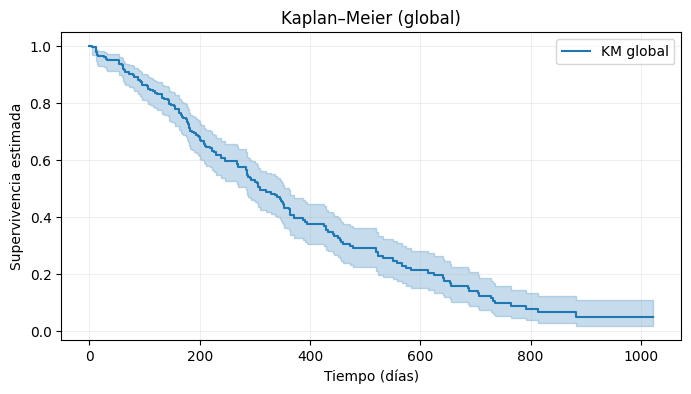

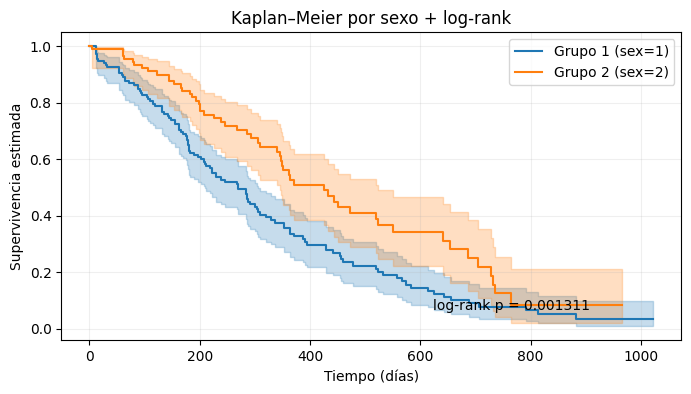

In [3]:
# CELDA — Kaplan–Meier (1) global y (2) por grupos + log-rank p-value

import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# --- 0) Definir tiempo y evento de forma robusta ---
time_col = "time"

# En el dataset lung, 'status' suele ser 1=censura, 2=evento (muerte)
# Hacemos una detección simple por si cambia el encoding.
status_vals = sorted(df["status"].dropna().unique().tolist())
if set(status_vals) == {1, 2}:
    df["event"] = (df["status"] == 2).astype(int)
elif set(status_vals) == {0, 1}:
    df["event"] = (df["status"] == 1).astype(int)
else:
    # fallback: asumimos que el valor máximo indica evento
    df["event"] = (df["status"] == max(status_vals)).astype(int)

event_col = "event"

print("Encoding detectado:", {"status_values": status_vals, "event_definition": "event=1 indica evento"})

# --- 1) Kaplan–Meier global ---
kmf = KaplanMeierFitter()

plt.figure(figsize=(8, 4))
kmf.fit(durations=df[time_col], event_observed=df[event_col], label="KM global")
ax = kmf.plot(ci_show=True)

ax.set_title("Kaplan–Meier (global)")
ax.set_xlabel("Tiempo (días)")
ax.set_ylabel("Supervivencia estimada")
ax.grid(True, alpha=0.2)
plt.show()

# --- 2) Kaplan–Meier por grupos (sexo) + log-rank ---
# Seleccionamos una variable binaria para comparar: 'sex' (habitualmente 1/2)
group_col = "sex"
groups = sorted(df[group_col].dropna().unique().tolist())

if len(groups) != 2:
    raise ValueError(f"'{group_col}' no tiene exactamente 2 grupos: {groups}. Elige otra variable binaria.")

g1, g2 = groups[0], groups[1]
df1 = df[df[group_col] == g1].copy()
df2 = df[df[group_col] == g2].copy()

# Log-rank
lr = logrank_test(
    df1[time_col], df2[time_col],
    event_observed_A=df1[event_col],
    event_observed_B=df2[event_col]
)
p = lr.p_value

# Etiquetas (si sex es 1/2, damos nombres; si no, mostramos el valor tal cual)
sex_map = {1: "Grupo 1 (sex=1)", 2: "Grupo 2 (sex=2)"}
label1 = sex_map.get(g1, f"Grupo {g1}")
label2 = sex_map.get(g2, f"Grupo {g2}")

km1 = KaplanMeierFitter()
km2 = KaplanMeierFitter()

plt.figure(figsize=(8, 4))
ax = plt.gca()

km1.fit(df1[time_col], event_observed=df1[event_col], label=label1).plot(ax=ax, ci_show=True)
km2.fit(df2[time_col], event_observed=df2[event_col], label=label2).plot(ax=ax, ci_show=True)

ax.set_title("Kaplan–Meier por sexo + log-rank")
ax.set_xlabel("Tiempo (días)")
ax.set_ylabel("Supervivencia estimada")
ax.grid(True, alpha=0.2)

# Mostrar p-value en la figura (posición relativa al eje)
ax.text(
    0.60, 0.10,
    f"log-rank p = {p:.4g}",
    transform=ax.transAxes
)

plt.show()


## 🧠 Aquí empieza el trabajo del investigador (tu trabajo)

A partir de este punto, el cuaderno deja de ser “seguir pasos” y pasa a ser **interpretación y criterio**.

✅ Tu tarea ahora es **leer** estas curvas:
- ¿Qué curva está por encima (mejor supervivencia)?
- ¿En qué tramo temporal se separan más?
- ¿El p-valor del log-rank apoya diferencias reales o no?

📌 Importante: el gráfico y el log-rank te dan una señal, pero **la conclusión final la construyes tú** con una interpretación razonada (clínica y estadística).

🔍 Si quieres estar más seguro/a, siéntete libre de:
- calcular medianas o supervivencia a tiempos concretos (p. ej. 200, 400 días)
- estimar número de eventos por grupo y proporción de censura
- probar otra estratificación (p. ej. por `ph.ecog` discretizado, o por edad en terciles)
- repetir log-rank con otro agrupamiento que tenga sentido

💡 Lo que se evalúa no es solo el “resultado”, sino que se note que razonas como investigador/a:
**qué comparas, por qué lo comparas, y qué puedes concluir (y qué no).**


Filas usadas en Cox: 213 (eliminadas por NA: 15)


,HR,IC95%_inf,IC95%_sup,p_value,Significativo_(IC95% excluye 1)
covariate,,,,,
ph.ecog,1.673822,1.307579,2.142647,0.000043,True
sex_2,0.553900,0.392810,0.781053,0.000754,True
age,1.013459,0.994514,1.032764,0.164954,False
wt.loss,0.991034,0.978187,1.004051,0.176139,False


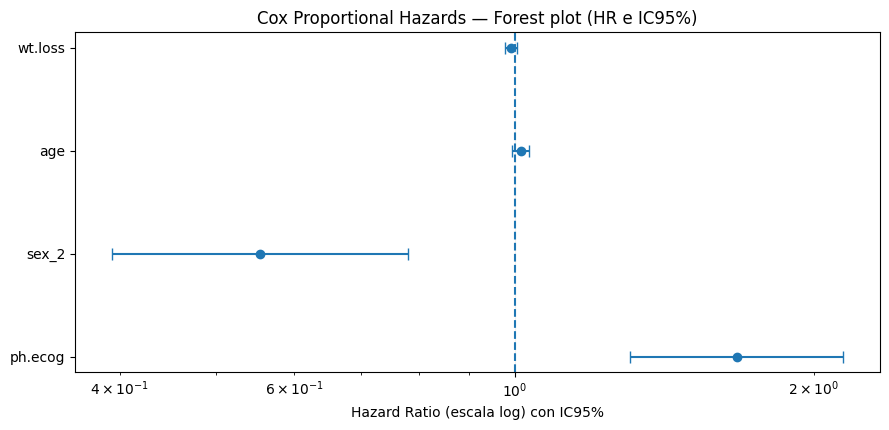

In [5]:
# CELDA — Cox PH: tabla + forest plot (HR con IC95% y significación visual)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter

# --- 0) Asegurar columnas de tiempo/evento ---
time_col = "time"
event_col = "event"
if event_col not in df.columns:
    status_vals = sorted(df["status"].dropna().unique().tolist())
    if set(status_vals) == {1, 2}:
        df[event_col] = (df["status"] == 2).astype(int)
    elif set(status_vals) == {0, 1}:
        df[event_col] = (df["status"] == 1).astype(int)
    else:
        df[event_col] = (df["status"] == max(status_vals)).astype(int)

# --- 1) Selección de covariables (el alumno puede ajustar) ---
# TODO (alumno): prueba otras combinaciones de covariables y discute el impacto.
covariates = ["age", "sex", "ph.ecog", "wt.loss"]

df_cox = df[[time_col, event_col] + covariates].copy()

# --- 2) Limpieza: dummies para categóricas + eliminar missing ---
# sex suele ser 1/2 en este dataset → lo tratamos como categórica
df_cox["sex"] = df_cox["sex"].astype("category")

# Dummies (drop_first=True evita colinealidad; sex_2 es "comparado con sex_1")
df_cox = pd.get_dummies(df_cox, columns=["sex"], drop_first=True)

n_before = len(df_cox)
df_cox = df_cox.dropna()
n_after = len(df_cox)
print(f"Filas usadas en Cox: {n_after} (eliminadas por NA: {n_before - n_after})")

# --- 3) Ajuste del modelo de Cox ---
cph = CoxPHFitter()
cph.fit(df_cox, duration_col=time_col, event_col=event_col)

# --- 4) Tabla clara con HR, IC95% y p-valor ---
summary = cph.summary.copy()

# lifelines ya incluye exp(coef) y sus IC; renombramos para lectura
out = summary[["exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]].copy()
out.columns = ["HR", "IC95%_inf", "IC95%_sup", "p_value"]
out["Significativo_(IC95% excluye 1)"] = (out["IC95%_inf"] > 1) | (out["IC95%_sup"] < 1)

display(out.sort_values("p_value"))

# --- 5) Forest plot educativo (HR con IC95%) — FIX robusto ---
plot_df = out.reset_index().copy()

# el nombre real de la primera columna tras reset_index es el nombre del índice (p.ej. 'covariate')
idx_col = plot_df.columns[0]
plot_df = plot_df.rename(columns={idx_col: "variable"})

# Orden por p-valor (más relevantes arriba)
plot_df = plot_df.sort_values("p_value", ascending=True)

y = np.arange(len(plot_df))
hr = plot_df["HR"].values
lo = plot_df["IC95%_inf"].values
hi = plot_df["IC95%_sup"].values

plt.figure(figsize=(9, 0.6*len(plot_df) + 2))
plt.errorbar(
    x=hr,
    y=y,
    xerr=[hr - lo, hi - hr],
    fmt="o",
    capsize=4
)

plt.axvline(1.0, linestyle="--")  # HR=1 (sin efecto)
plt.yticks(y, plot_df["variable"].values)
plt.xscale("log")
plt.xlabel("Hazard Ratio (escala log) con IC95%")
plt.title("Cox Proportional Hazards — Forest plot (HR e IC95%)")
plt.grid(True, axis="x", alpha=0.2)
plt.tight_layout()
plt.show()


## 3) 🧬 Modelo de Cox (multivariable) + “forest plot” (HR e IC95%)

Ahora ajustaremos un **modelo de Cox** para cuantificar cómo se asocia cada covariable con el riesgo del evento.

📌 Cómo leer el resultado:
- El modelo estima **Hazard Ratios (HR)**.
- **HR > 1** → mayor riesgo (peor pronóstico)
- **HR < 1** → menor riesgo (mejor pronóstico)
- Si el **IC95% del HR NO incluye 1**, la asociación suele considerarse **estadísticamente significativa** (p < 0.05).

⬇️ La siguiente celda:
1) ajusta el modelo de Cox,
2) muestra una tabla con HR, IC95% y p-valor,
3) dibuja un **forest plot** (muy útil para interpretar rápidamente significación y magnitud).


## ✅ Cierre del bloque (¡bien hecho!)

Si has llegado hasta aquí con el cuaderno ejecutando correctamente, ya has completado un flujo de análisis de supervivencia muy parecido al que se usa en investigación clínica real.

### 💡 Qué has aprendido (competencias adquiridas)
- Entender y trabajar con **censura** (por qué existe y cómo afecta al análisis)
- Estimar y representar supervivencia con **Kaplan–Meier**
- Comparar grupos con el **test log-rank** (y saber qué concluye y qué no)
- Ajustar un modelo multivariable con **Cox Proportional Hazards**
- Interpretar **HR**, **IC95%** y significación (IC que cruza/no cruza 1)
- Conectar estadística con lenguaje clínico: *qué significa “más riesgo” o “mejor pronóstico”*

### 🧠 Recordatorio importante
Una buena conclusión no es “p < 0.05”, sino una respuesta razonada:
- ¿qué variables importan?
- ¿en qué dirección?
- ¿con qué incertidumbre (IC95%)?
- ¿qué limitaciones tiene el dataset o el modelo?

🚀 ¡Ánimo con el informe técnico! Si lo estructuras bien (métodos → resultados → interpretación), ya estás trabajando como un/a analista de datos en salud.
